# Hackathon Recreation
Updated on 2020-6-16 Tuesday

The notebook attempts to recreate the hackathon results - results are saved into to csv file.

```
from IPython.display import display, HTML
display(HTML(df.sort_values('Strategy').to_html()))
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from modules.utils import parse_tif_dir
from modules.registration import register_images
import modules.nonrigid_registration as nr

import numpy as np
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from pandas import read_csv, DataFrame
from tqdm.notebook import tqdm
import seaborn as sns
import random
from skimage import transform

In [14]:
# parse image data directories into dict form
filepaths_registered = parse_tif_dir('/media/jc/NVME_SSD/SageBionetworks/normalBreastRegistered/')
filepaths_unregistered = parse_tif_dir('/media/jc/NVME_SSD/SageBionetworks/normalBreast/')

# save path
save_path = '../Data_Files/recreation_results'

## OHSU Registration Distances
OHSU provided already registered images, we can estimate the distance between the rounds by using the DAPI channel in each round. Note that these images are already registered so make sure not to try registering them again.

In [15]:
# header for DataFrame used to create output CSV file
df = DataFrame(columns=['Moving', 'Strategy', 'Distance', 'Target', 'Channel', 'Dataset'])

target_round = 1

# target should be round 1 and DAPI channel (first channel)
target = imread(filepaths_registered[target_round][1])

# go through registered filepaths
for _round, filepaths in tqdm(filepaths_registered.items()):
    # skip round 0 (unlabeled round) and 1 (target round)
    if _round not in [0, 1]:
        # grab DAPI image (first channel) from this round
        moving = imread(filepaths[1])
            
        # get distance, leave methods parameter as None to not apply a registration
        images, kpts, distances = register_images(moving, target, methods=['linear'])
                     
        df = df.append({
            'Moving': f'R{_round}',
            'Strategy': 'Linear; Keypoint (OHSU; DAPI)', 
            'Distance': distances[0],
            'Target': f'R{target_round}',
            'Channel': 'DAPI',
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
# save to CSV file, append a version number so we can load intemediate results
df.to_csv(save_path + '1.csv', index=False)

## Distances with unregistered images before / after linear registration
This will allow comparison of linear registration with DAPI channel vs OHSU method. The distances with the unregistered images will give a comparable measure of how much improvement there was.

In [16]:
# load CSV saved in last section
df = read_csv(save_path + '1.csv')

target_round = 1

# target should be round 1 and DAPI channel (first channel)
target = imread(filepaths_unregistered[target_round][1])

# go through the unregistered filepaths
for _round in tqdm(filepaths_unregistered.keys()):
    # skip round 0 (unlabeled round) and 1 (target round)
    if _round not in [0, 1]:
        # grab DAPI image (first channel) from this round
        moving = imread(filepaths_unregistered[_round][1])
        
        images, kpts, distances = register_images(moving, target, ['none', 'linear'])
                
        df = df.append({
            'Moving': f'R{_round}', 
            'Strategy': 'Unaligned (DAPI)', 
            'Distance': distances[0],
            'Target': f'R{target_round}', 
            'Channel': 'DAPI', 
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
        df = df.append({
            'Moving': f'R{_round}', 
            'Strategy': 'Linear; Keypoint (DAPI)', 
            'Distance': distances[1],
            'Target': f'R{target_round}', 
            'Channel': 'DAPI', 
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
# save to CSV file, append a version number so we can load intemediate results
df.to_csv(save_path + '2.csv', index=False)

## Distances with channel 2 (autoflourescence)
Instead of using channel 1 (which is DAPI and save in each round / but shifted unpredictably) using channel 2 in each round. This is hypothesized to use autoflourescence to register images instead of other co-occuring features. Note that this could potentially fail because, unlike DAPI, the channels may not have a lot of usable co-occuring features. If this fails then leave entry blank.

As with the linear DAPI case, calculate distances with and without registration.

In [17]:
# load CSV saved in last section
df = read_csv(save_path + '2.csv')

target_round = 1

# target should be round 1 and second channel
target = imread(filepaths_unregistered[target_round][2])

# go through the unregistered filepaths
for _round in tqdm(filepaths_unregistered.keys()):
    if _round not in [0, 1]:
        # grab second channel image from this round
        moving = imread(filepaths_unregistered[_round][2])
        
        # catch errors
        try:
            images, kpts, distances = register_images(moving, target, ['none', 'linear'])
        except:
            # if registering image failed then leave distances blank
            distances = ['', '']
                
        df = df.append({
            'Moving': f'R{_round}',
            'Strategy': 'Unaligned (AF)', 
            'Distance': distances[0],
            'Target': f'R{target_round}', 
            'Channel': 'AF', 
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
        df = df.append({
            'Moving': f'R{_round}',
            'Strategy': 'Linear; Keypoint (AF)', 
            'Distance': distances[1],
            'Target': f'R{target_round}', 
            'Channel': 'AF', 
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
# save to CSV file, append a version number so we can load intemediate results
df.to_csv(save_path + '3.csv', index=False)

## Non-rigid Alignment on AF
Use non-rigid registration as done in the Hackathon using the AF channel.

In [ ]:
# create channel signal masks
from skimage import io
from os import makedirs

target = imread(filepaths_unregistered[1][2])
moving = imread(filepaths_unregistered[2][2])

src_dir = "/media/jc/NVME_SSD/SageBionetworks/normalBreast/"
dst_dir = '/media/jc/NVME_SSD/SageBionetworks/normalBreast_masks/'

makedirs(dst_dir, exist_ok=True)

for i in range(1, 12):
    print('mask:', i)
    # get filepaths for this round, excluding channel 1 (DAPI channel)
    round_f_list = nr.get_imgs_in_round(src_dir, i)
    
    signal_mask = nr.get_tissue_mask(round_f_list)[0]
    
    # save output masks
    io.imsave("".join([dst_dir, str(i).zfill(2), "_tissue_mask.png"]), signal_mask)

In [27]:
# non-rigid registration
from pathlib import Path
import re
import SimpleITK as sitk

# object handles on the directories with images / masks
datapath = Path('/media/jc/NVME_SSD/SageBionetworks/normalBreast/')
outpath = Path('/media/jc/NVME_SSD/SageBionetworks/normalBreast_masks/')

# grab all channel 2 images, exclude quench rounds and round 0
ims = []
for filepath in datapath.glob('*_c2_*'):
    if not re.search('R\d{1,2}Q|R0_', str(filepath)):
        if re.search('R1_', str(filepath)):
            # target is round 1
            target = filepath
        else:
            ims.append(filepath)
ims = sorted(ims)
        
# registration models
reg_models = [
    '../registration/elx_reg_params/rigid_largersteps.txt',
    '../registration/elx_reg_params/nl.txt'
]

for idx, image in enumerate(ims):
    filename = str(image).split('/')[-1]
    print(str(image).split('/')[-1], '\n')

    # directory is placed in outpath under the name of the image (no ext)
    out_folder = outpath / image.stem

    # create the directory if it does not exist
    if out_folder.is_dir() is False:
        out_folder.mkdir()

    _ = nr.register_2D_images(
        str(image),
        0.2645833333,
        str(target),
        0.2645833333,
        reg_models,
        str(out_folder),
    )

    rig_tform = sorted(Path(out_folder).glob('*.0.txt'))
    nl_tform = sorted(Path(out_folder).glob('*.1.txt'))
    tform_list = [str(rig_tform[0]), str(nl_tform[0])]
    
    # transform images should be done on DAPI channel
    dapi_filepath = str(image).replace('_c2_', '_c1_')
    im = nr.transform_2D_image(
            dapi_filepath,
            0.2645833333,
            tform_list,
            im_output_fp='',
            write_image=False
    )

    out_im_path = image.stem + '_registered.tiff'
    sitk.WriteImage(im, str(out_folder / out_im_path), True)

[PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R10_LamB1.H3K4.ColIV.FoxP3_SMT130-4_2019_05_23__13_36__1860S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R11_S100.PDL1.LamB2.CD3_SMT130-4_2019_05_24__14_11__1871S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R2_CK5.HER2.ER.CD45_SMT130-4_2019_05_09__21_52__1654S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R3_aSMA.CD68.CD4.Ecad_SMT130-4_2019_05_13__15_50__1718-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R4_Vimentin.AR.CD31.CD44_SMT130-4_2019_05_14__11_40__1731S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R5_CK7.CK14.Ki67.PgR_SMT130-4_2019_05_15__14_21__1754S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc/NVME_SSD/SageBionetworks/normalBreast/R6_pHH3.pS6.pERK.CD20_SMT130-4_2019_05_19__23_40__1797S-Scene-012_c2_ORG.tif'), PosixPath('/media/jc

### NOTE - move all the registered images to the  normalBreast_nlRegistered Folder
By default the images say channel 2 on the name even though they are channel 1 (this will in the future need to be cleaned up).

In [32]:
# load CSV saved in last section
df = read_csv(save_path + '3.csv')

target_round = 1

filepaths_nlregistered = parse_tif_dir('/media/jc/NVME_SSD/SageBionetworks/normalBreast_nlRegistered/')

# registering to round 1 DAPI channel
target = imread(filepaths_unregistered[target_round][1])

for _round in tqdm(filepaths_nlregistered.keys()):
    if _round not in [0, 1]:
        moving = imread(filepaths_nlregistered[_round][1])
#         
#         try:
        images, kpts, distances = register_images(moving, target, methods=['none'])
#         except:
#             errors = ['']
        
        df = df.append({
            'Moving': f'R{_round}',
            'Strategy': 'Non-linear; Intensity (AF)',
            'Distance': distances[0],
            'Target': f'R{target_round}',
            'Channel': 'AF',
            'Dataset': 'BrCa (OHSU)'
        }, ignore_index=True)
        
# save to CSV file, append a version number so we can load intemediate results
df.sort_values('Strategy').to_csv(save_path + '4.csv', index=False)

## Plot Comparison of Hackathon and Recreation

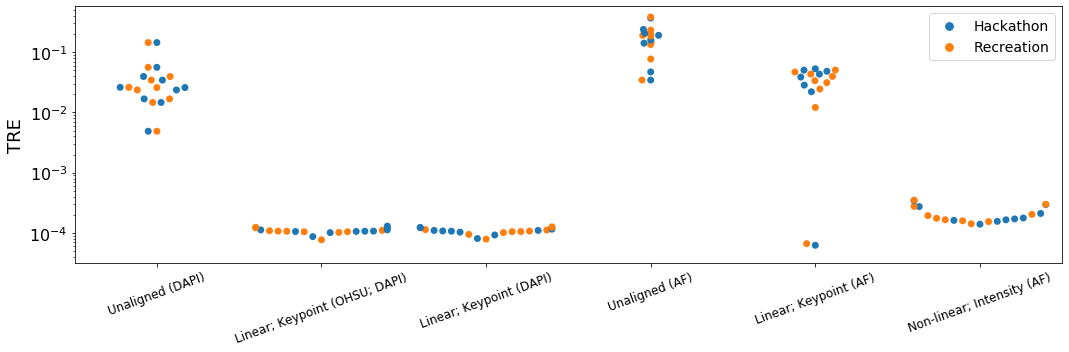

In [39]:
df_hackathon = read_csv('../Data_Files/hackathon2019_results.csv')
df_hackathon['Category'] = ['Hackathon'] * df_hackathon.shape[0]

df_recreation = read_csv(save_path + '4.csv')
df_recreation['Category'] = ['Recreation'] * df_recreation.shape[0]

df_combined = df_hackathon.append(df_recreation, ignore_index=True)

# plot results in swarmplot, recreating slide 9 in presentation
plt.figure(figsize=(15,5))
ax = sns.swarmplot(data=df_combined, x='Strategy', y='Distance', hue='Category',
              order=['Unaligned (DAPI)', 'Linear; Keypoint (OHSU; DAPI)', 'Linear; Keypoint (DAPI)',
                     'Unaligned (AF)', 'Linear; Keypoint (AF)', 'Non-linear; Intensity (AF)',
                     ], s=7)
ax.set_yscale('log')
_max, _min = max(df_combined.Distance), min(df_combined.Distance)
diff = _max - _min
ax.set_ylim([_min -0.5*_min, _max + 0.5*_max])
plt.ylabel('TRE', fontsize=18)

plt.yticks(fontsize=16)
plt.xticks(rotation=20, fontsize=12)
plt.legend(fontsize=14)
plt.xlabel('')

plt.tight_layout()
plt.savefig('hackathonRecreationResults.png', dpi=300)
plt.show()

In [ ]:
df.sort_values('Strategy').to_csv(save_path, index=False)